In [5]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [6]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../Dataset/ACB-Historical-Data_Group 9.csv')
df1=df.reset_index()['Price']

In [7]:
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [8]:
df1=df.reset_index()['Price']

In [9]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [11]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [14]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 76ms/step - loss: 0.1338 - val_loss: 0.0096
Epoch 2/100
13/13 [==============================] - 1s 39ms/step - loss: 0.0183 - val_loss: 0.0030
Epoch 3/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0088 - val_loss: 0.0057
Epoch 4/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0059 - val_loss: 7.1721e-04
Epoch 5/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0023 - val_loss: 6.6734e-04
Epoch 6/100
13/13 [==============================] - 0s 34ms/step - loss: 9.3867e-04 - val_loss: 6.6448e-04
Epoch 7/100
13/13 [==============================] - 0s 34ms/step - loss: 6.4942e-04 - val_loss: 7.2024e-04
Epoch 8/100
13/13 [==============================] - 0s 34ms/step - loss: 6.4589e-04 - val_loss: 6.8269e-04
Epoch 9/100
13/13 [==============================] - 0s 33ms/step - loss: 6.2651e-04 - val_loss: 6.5025e-04
Epoch 10/100
13/13 [==============================] - 0s 33m

In [16]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 30ms/step


In [17]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [20]:
x_input = val_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

[0.8752654]
67
[0.86940587]
68
[0.8636878]
69
[0.8581382]
70
[0.85275763]
71
[0.8475425]
72
[0.8424877]
73
[0.83758587]
74
[0.83283067]
75
[0.82821554]
76
[0.82373405]
77
[0.81938064]
78
[0.8151503]
79
[0.8110381]
80
[0.8070397]
81
[0.80315113]
82
[0.79936826]
83
[0.79568803]
84
[0.79210675]
85
[0.78862107]
86
[0.7852279]
87
[0.7819244]
88
[0.7787078]
89
[0.7755754]
90
[0.7725245]
91
[0.7695529]
92
[0.76665777]
93
[0.763837]
94
[0.7610883]
95
[0.7584096]
96


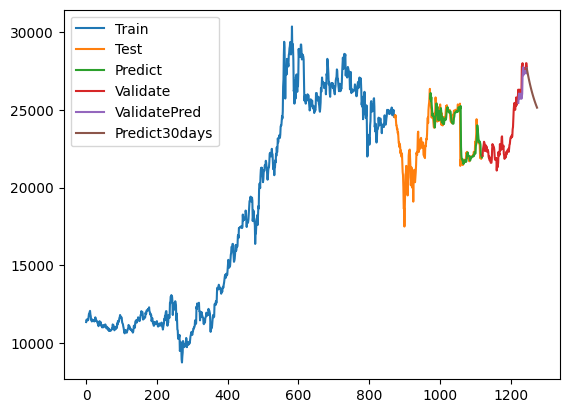

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [22]:
import numpy as np

# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

# Tính MDA (Mean Directional Accuracy)
valid_mda = np.mean(np.sign(yval[1:] - yval[:-1]) == np.sign(y_pred_val[1:] - y_pred_val[:-1])) * 100
test_mda = np.mean(np.sign(ytest[1:] - ytest[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])) * 100
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)


Validation RMSE: 26684.77129023961
Testing RMSE: 23732.762628808858
Validation MAPE: 3174496.485163307
Testing MAPE: 3457668.5554088596
Validation MDA: 42.36111111111111
Testing MDA: 43.18108195659216
